<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "1pct_10k/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [3]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - TransformerConv(512, 64, heads=4): x,

In [4]:
# test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

# print(f"Test Loss: {test_loss}")
# print(f"R-squared: {r_squared}")
# print(f"Baseline Loss: {baseline_loss}")

# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 8
Test Loss: 3.5193258013044084
R-squared: 0.8158540725708008
Baseline Loss: 133.78128051757812


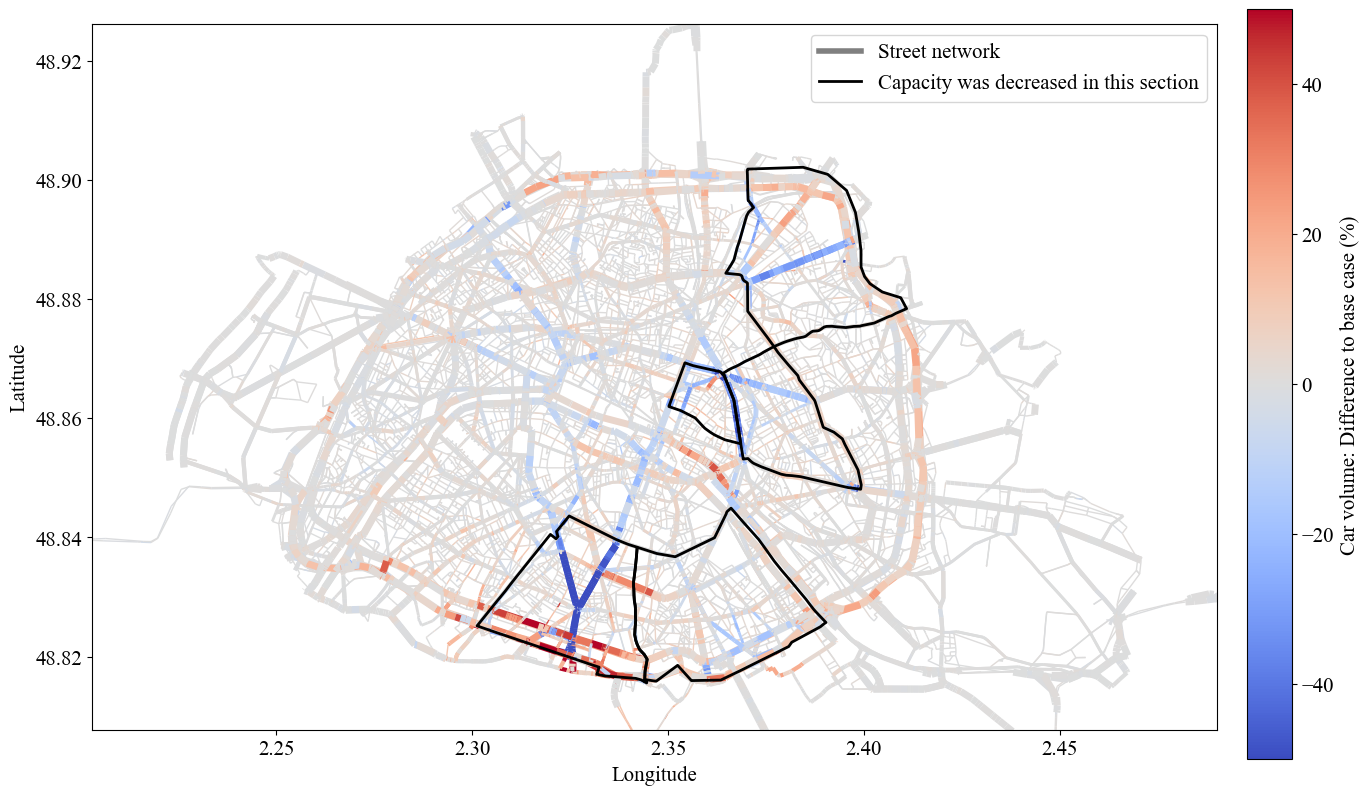

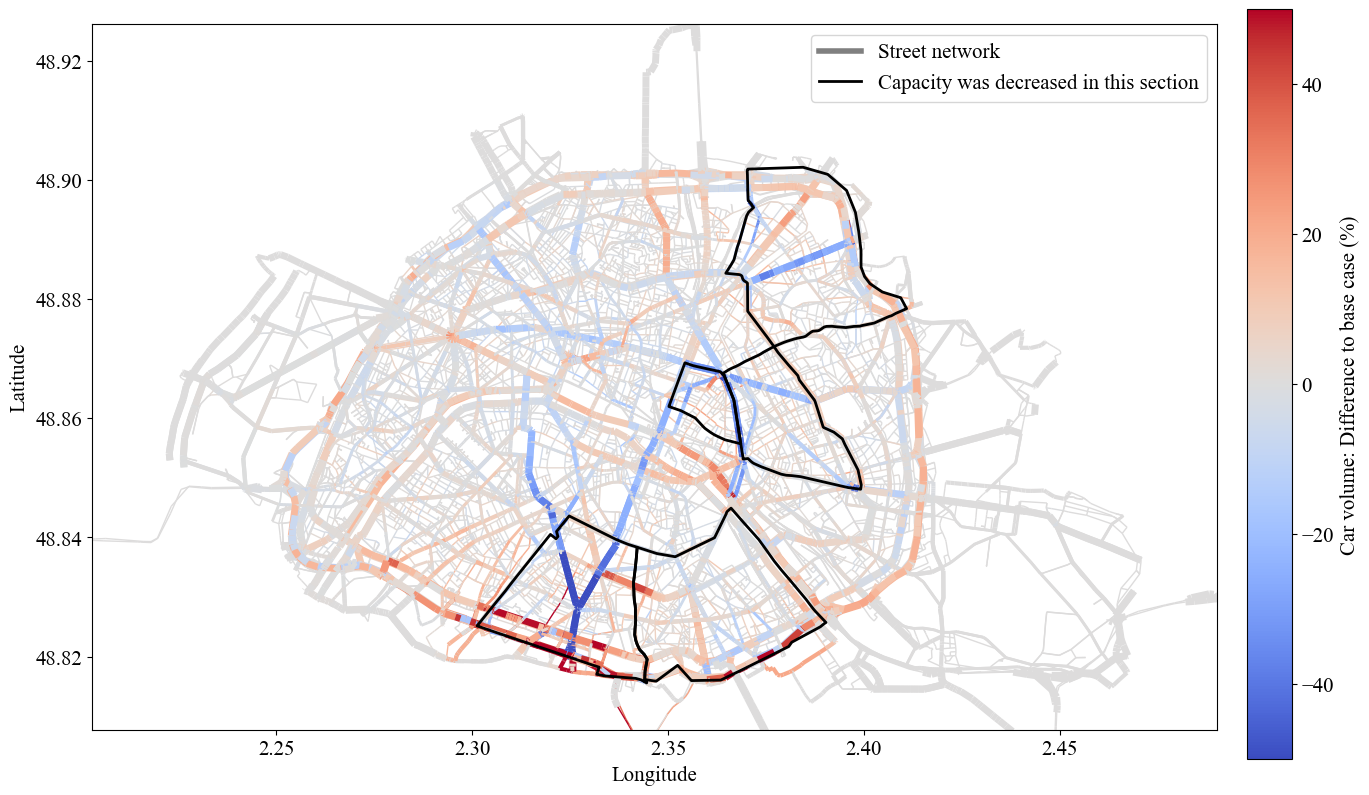

In [5]:
fixed_norm_max = 50

for i in range(10):
    if i != 8:
        continue
    # if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
    #     continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [6]:
# Generalize the creation of gdfs for a range of indices
gdfs = []
for i in range(len(test_set_loader.dataset)):
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf['capacity_reduction_rounded'] = gdf['capacity_reduction'].round(decimals=3)
    gdf['highway'] = gdf['highway'].map(hf.highway_mapping)
    gdfs.append(gdf)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


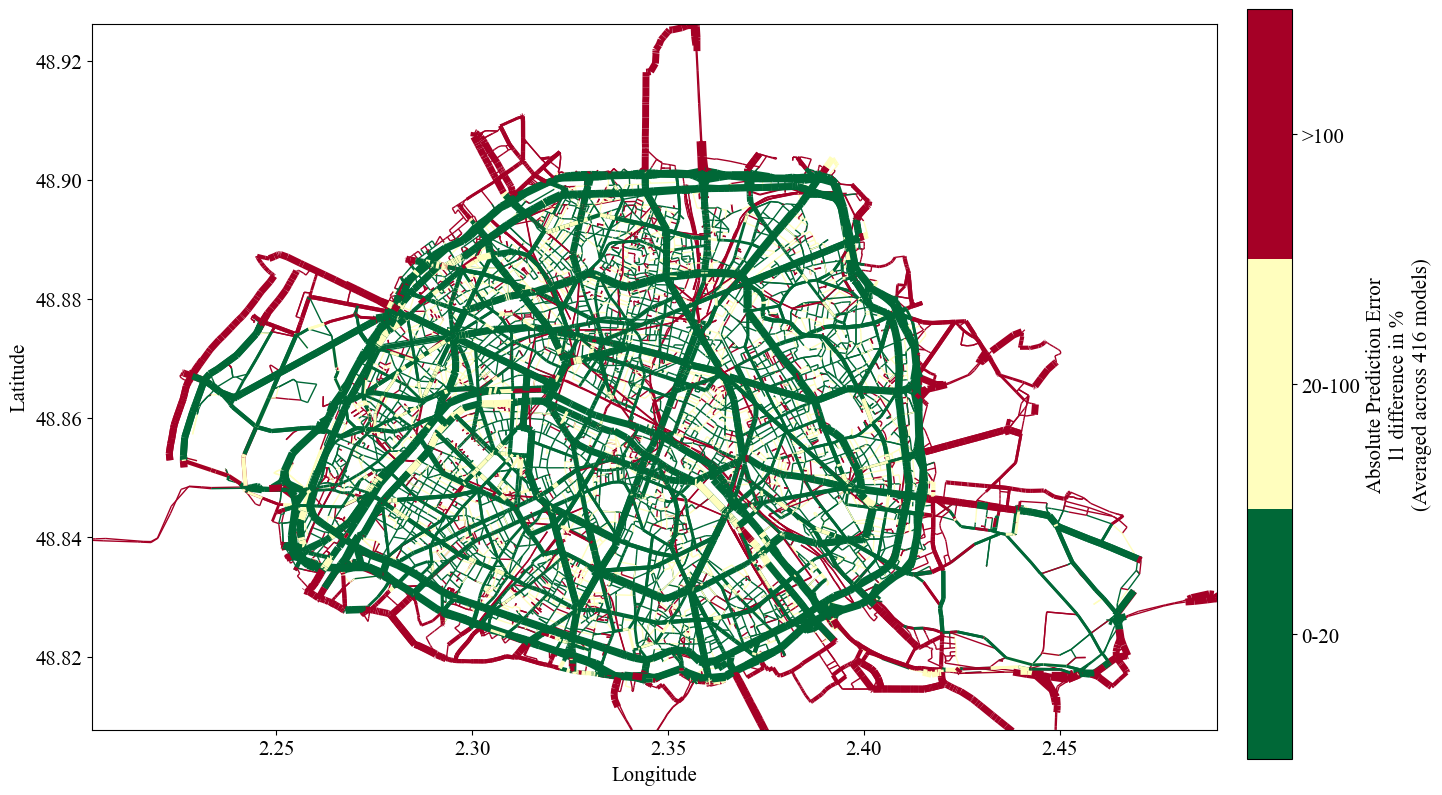

In [7]:
# For absolute differences in number of vehicles
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(20, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1"
)

In [8]:
# # For absolute differences in number of vehicles
# result_gdf = hf.plot_average_prediction_differences(
#     gdf_inputs=gdfs,
#     scale_type="discrete",
#     discrete_thresholds=(20, 40, 60, 80, 100),
#     save_it=True,
#     use_fixed_norm=True,
#     fixed_norm_max=100,
#     use_absolute_value_of_difference=True,
#     use_percentage=True,
#     disagreement_threshold=None,
#     result_path=result_path,
#     loss_fct="mse"
# )

In [9]:
# fixed_norm_max = 50

# for i in range(100):
#     if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#                             number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [10]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index
indices_roads_with_highway_trunk = gdf_with_og_values[gdf_with_og_values['highway'].isin([0])].index
indices_roads_with_highway_residential_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([4])].index
indices_roads_with_highway_living_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([5])].index

tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index
indices_roads_with_highway_primary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index
indices_roads_with_highway_sec_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([2])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_sec_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([2])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index
indices_roads_with_highway_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index


def compute_correlations_scipy(predictions, targets):
    """
    Compute correlations using scipy (for verification)
    """
    # pred_np = predictions.detach().cpu().numpy()
    # target_np = targets.detach().cpu().numpy()
    
    spearman_corr, _ = stats.spearmanr(predictions, targets)
    pearson_corr, _ = stats.pearsonr(predictions, targets)
    
    return spearman_corr, pearson_corr

In [11]:
# Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters['length'] = gdf_in_meters.length
total_length = gdf_in_meters['length'].sum() / 1000
print(f"Total length of the street network: {total_length:.2f} km")
gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")

Total length of the street network: 2872.02 km
Total length of the street network with capacity reductions: 210.73 km


In [12]:
# Define road types and their corresponding indices
road_types = {
    "All Roads": gdf_with_og_values.index,
    "Trunk Roads": indices_roads_with_highway_trunk,
    "Primary Roads": indices_roads_with_highway_primary_,
    "Secondary Roads": indices_roads_with_highway_sec,
    "Tertiary Roads": indices_roads_with_highway_tertiary,
    "Residential Streets": indices_roads_with_highway_residential_street,
    "Living Streets": indices_roads_with_highway_living_street,
    "Roads with Capacity Reduction": indices_roads_with_cap_reduction,
    "Roads with No Capacity Reduction": indices_roads_with_no_cap_reduction,
    "Roads with Highway Primary, Secondary, or Tertiary and Capacity Reduction": indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction,
    "Roads with Highway Primary, Secondary, or Tertiary and No Capacity Reduction": indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction,
    "Roads with Highway Primary, Secondary, or Tertiary": indices_roads_with_highway_primary_sec_tertiary,
    "Roads with Highway Primary and Capacity Reduction": indices_roads_with_highway_primary_and_cap_reduction,
    "Roads with Highway Primary and No Capacity Reduction": indices_roads_with_highway_primary_and_not_cap_reduction,
    "Roads with Highway Secondary and Capacity Reduction": indices_roads_with_highway_sec_and_cap_reduction,
    "Roads with Highway Secondary and No Capacity Reduction": indices_roads_with_highway_sec_and_not_cap_reduction,
    "Roads with Highway Tertiary and Capacity Reduction": indices_roads_with_highway_tertiary_and_cap_reduction,
    "Roads with Highway Tertiary and No Capacity Reduction": indices_roads_with_highway_tertiary_and_not_cap_reduction,   
}


def validate_model_with_interpretable_error(indices, gdf):
    loss_fct_l1 = torch.nn.L1Loss()
    loss_fct_l2 = torch.nn.MSELoss()
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    mean_car_vol = gdf.loc[indices, 'vol_base_case'].mean()
    variance = gdf.loc[indices, 'variance'].mean()
    std_dev = gdf.loc[indices, 'std_dev'].mean()
    std_dev_multiplied = gdf.loc[indices, 'std_dev_multiplied'].mean()
    cv_percent = gdf.loc[indices, 'cv_percent'].mean()
    
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    
    spearman_corr, pearson_corr = compute_correlations_scipy(predicted_vals, actual_vals)    
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    
    l1_loss = loss_fct_l1(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    l2_loss = loss_fct_l2(torch.tensor(actual_vals), torch.tensor(predicted_vals))

    l1_naive = loss_fct_l1(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))    
    l2_naive = loss_fct_l2(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    
    print(" ")
    print(f"Road Type: {road_type}")
    print(f"Number of observations: {len(indices)}")
    print(f"Mean Car Volume: {mean_car_vol}")

    print(f"R-squared: {round(r_squared.item(), 2)}")
    print(f"MSE Loss: {l2_loss}")
    print(f"Naive MSE Loss: {l2_naive}")
    print(f"Variance: {variance}")

    print(f"L1 Loss: {l1_loss}")
    print(f"Naive L1 loss: {l1_naive}")
    print(f"Standard Deviation Multiplied: {std_dev_multiplied}")

    print(f"Spearman Correlation: {spearman_corr}")
    print(f"Pearson Correlation: {pearson_corr}")
    
    print(f"Standard Deviation: {std_dev}")
    print(f"Coefficient of Variation: {cv_percent}")
    print(" ")
    
    return {
        'road_type': road_type,
        'number_of_observations': len(indices),
        'mean_car_vol': mean_car_vol,
        'r_squared': r_squared,
        'mse': l2_loss,
        'naive_mse': l2_naive,
        'l1': l1_loss,
        'naive_l1': l1_naive,
        'variance': variance,
        'std_dev': std_dev,
        'std_dev_normalized': std_dev_multiplied,
        'spearman': spearman_corr,
        'pearson': pearson_corr,
        'cv_percent': cv_percent
    }

# Collect metrics for each road type
metrics_by_type = {}
for road_type, indices in road_types.items():
    metrics_by_type[road_type] = validate_model_with_interpretable_error(indices, gdf_with_og_values)

 
Road Type: All Roads
Number of observations: 31635
Mean Car Volume: 50.908044134359926
R-squared: 0.82
MSE Loss: 24.63528060913086
Naive MSE Loss: 133.78126525878906
Variance: 8.570391818197557
L1 Loss: 2.6822750568389893
Naive L1 loss: 4.20802116394043
Standard Deviation Multiplied: 1.6732561654633888
Spearman Correlation: 0.4793443872062438
Pearson Correlation: 0.903535189037807
Standard Deviation: 2.097115607525589
Coefficient of Variation: 19.472651081093208
 
 
Road Type: Trunk Roads
Number of observations: 933
Mean Car Volume: 484.6030725259021
R-squared: 0.63
MSE Loss: 88.0787582397461
Naive MSE Loss: 238.12945556640625
Variance: 18.322837081548283
L1 Loss: 5.663949489593506
Naive L1 loss: 10.645626068115234
Standard Deviation Multiplied: 2.8748479939242175
Spearman Correlation: 0.7096772648439454
Pearson Correlation: 0.8034474991455149
Standard Deviation: 3.603087633418326
Coefficient of Variation: 4.798760132112466
 
 
Road Type: Primary Roads
Number of observations: 5295
Me

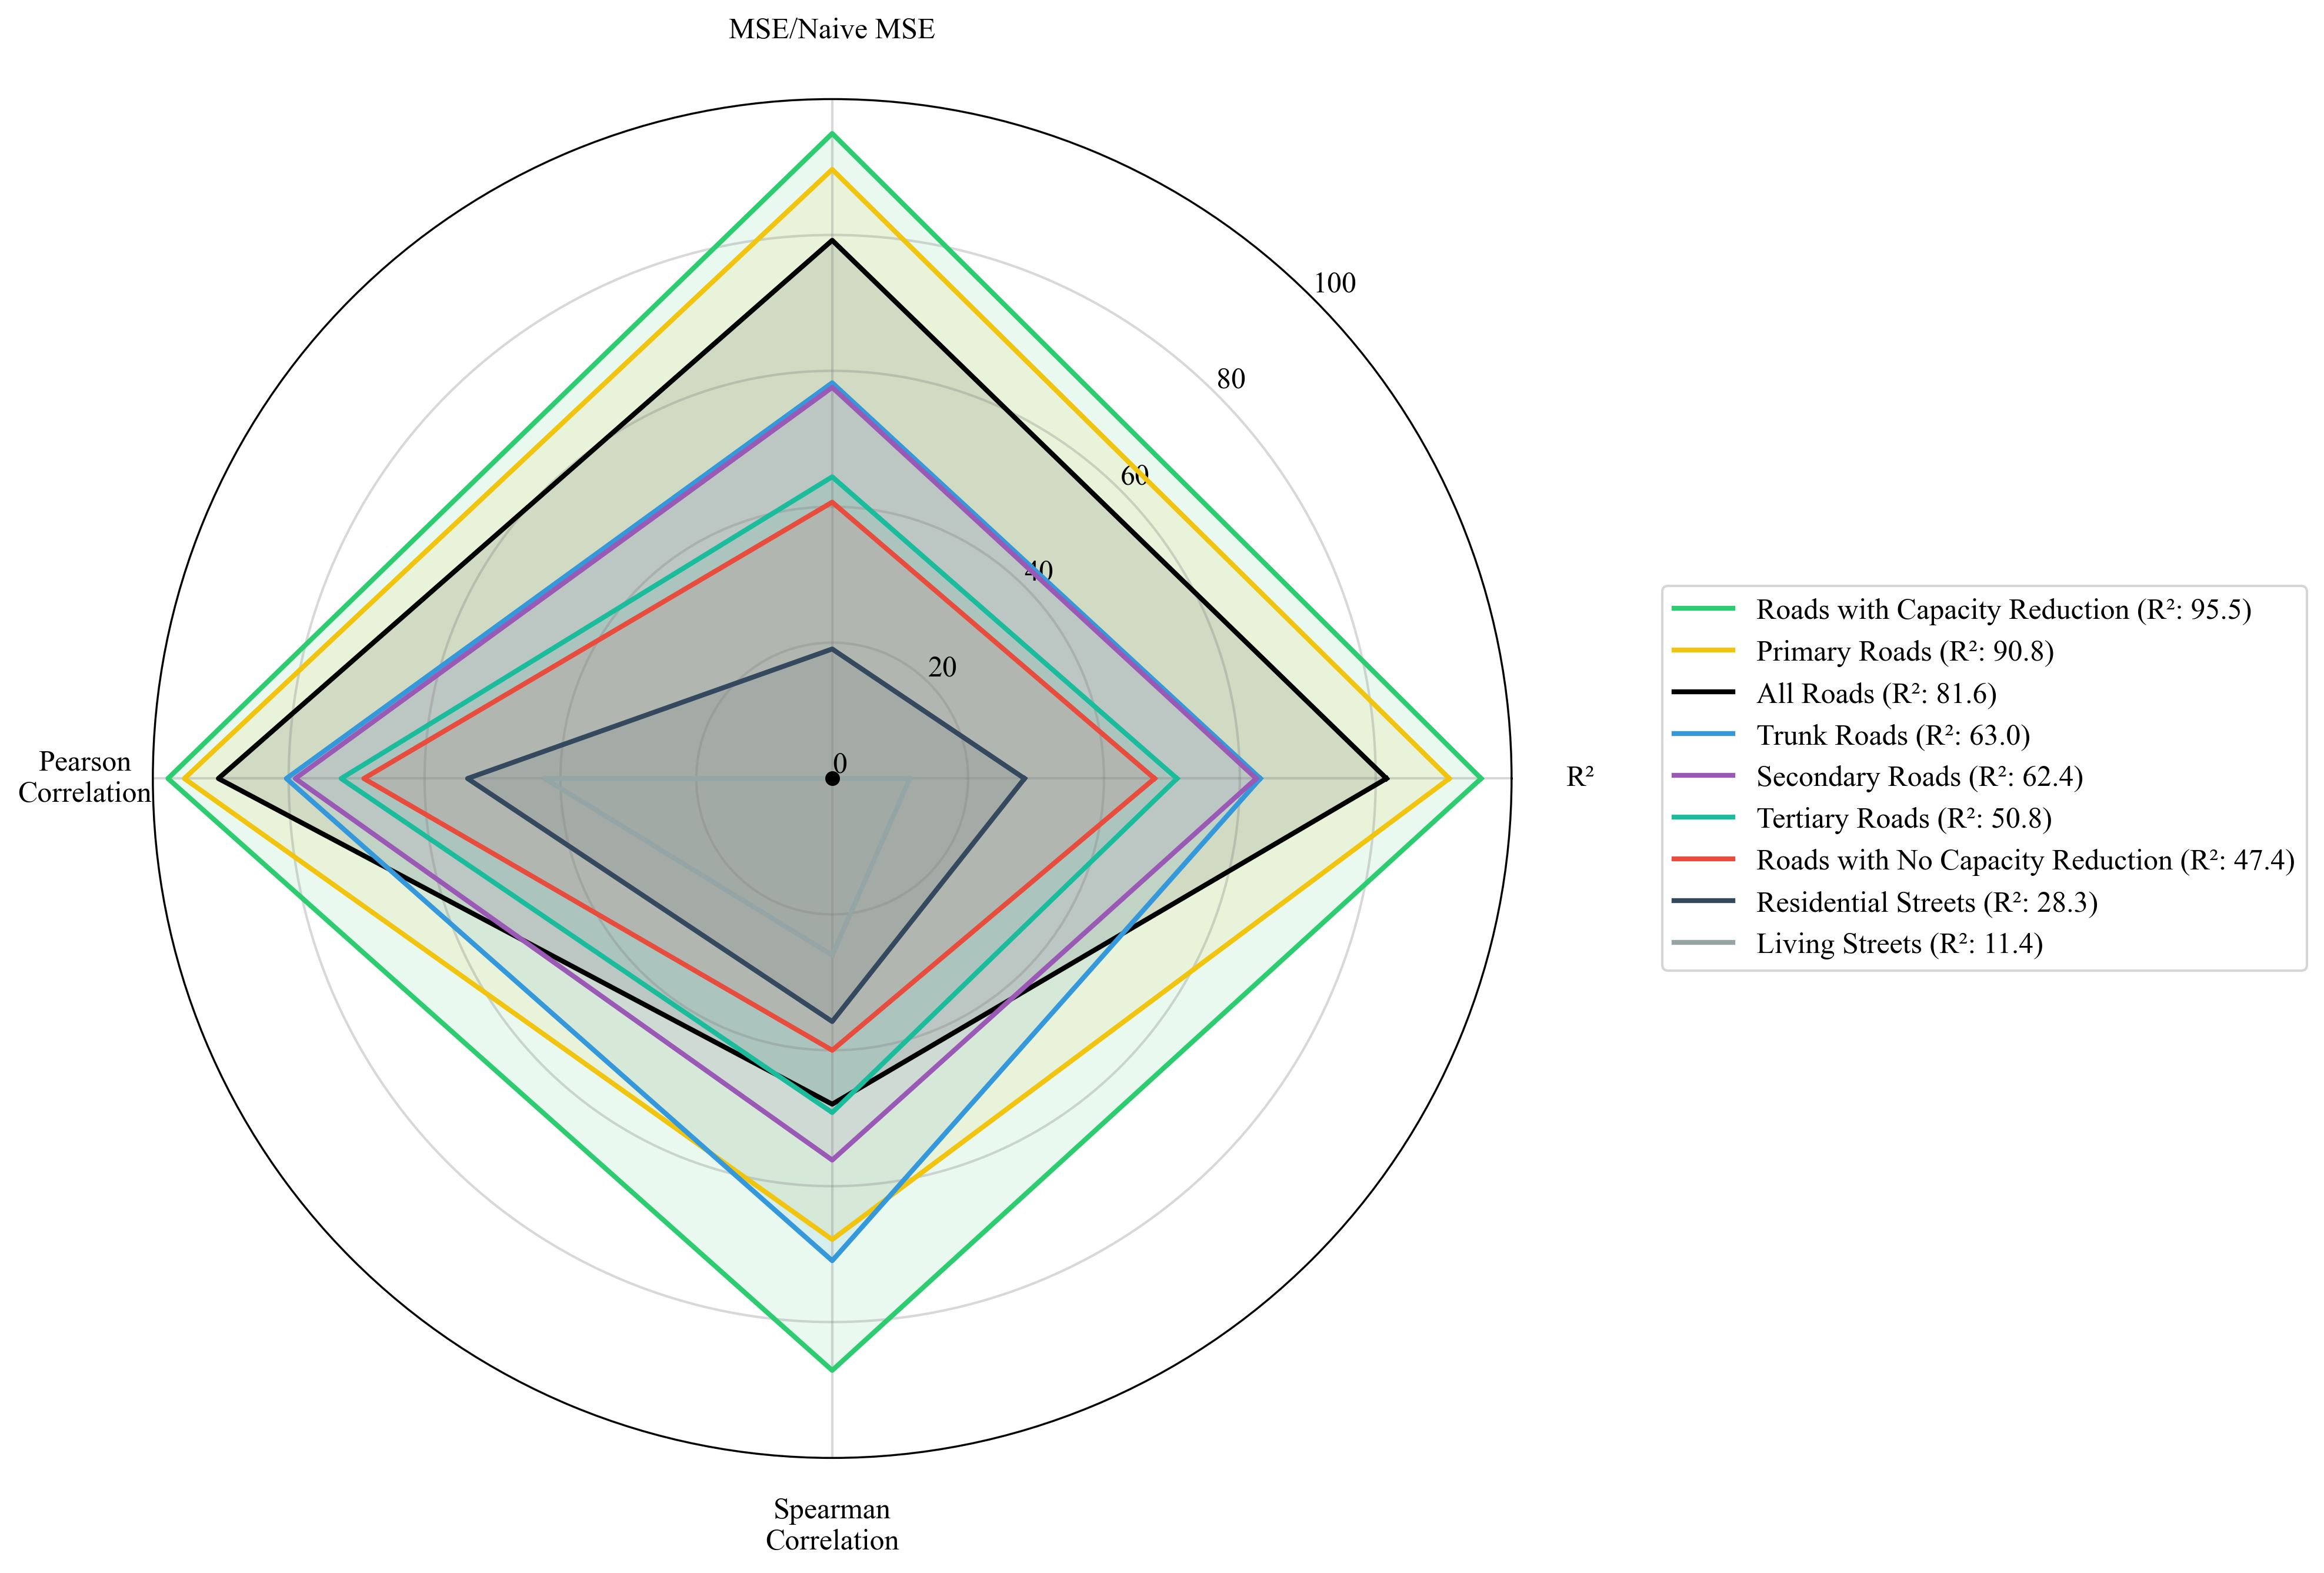

In [17]:
def create_correlation_radar_plot(metrics_by_type, selected_metrics=None):

    """
    Create a radar plot for model performance metrics.
    
    Args:
        metrics_by_type (dict): Dictionary containing metrics for each road type
        selected_metrics (list, optional): List of metrics to display. Each metric should be a dict with:
            - 'id': identifier in metrics_by_type
            - 'label': display label
            - 'transform': function to transform the value (or None to use directly)
            - 'y_pos': y-position of the label
    """
    # Default metrics if none specified
    if selected_metrics is None:
        selected_metrics = [
            {
                'id': 'r_squared',
                'label': 'R²',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'mse_ratio',
                'label': 'MSE/Naive MSE',
                'transform': lambda x, max_ratio: (1 - x/max_ratio) * 100,
                'y_pos': -0.1
            },
            {
                'id': 'pearson',
                'label': 'Pearson\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'spearman',
                'label': 'Spearman\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            }
        ]
    
    # Select specific road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    filtered_metrics = {rt: metrics_by_type[rt] for rt in selected_types}
    road_types = sorted(filtered_metrics.keys(), 
                       key=lambda x: filtered_metrics[x]['r_squared'],
                       reverse=True)
    
    # Calculate maximum ratios for normalization if needed
    max_ratios = {}
    for metric in selected_metrics:
        if 'ratio' in metric['id']:
            if metric['id'] == 'mse_ratio':
                max_ratios['mse'] = max(metrics_by_type[rt]['mse'] / 
                                      metrics_by_type[rt]['naive_mse'] 
                                      for rt in road_types)
            elif metric['id'] == 'l1_ratio':
                max_ratios['l1'] = max(metrics_by_type[rt]['l1'] / 
                                     metrics_by_type[rt]['naive_l1'] 
                                     for rt in road_types)
    
    # Setup plot
    num_vars = len(selected_metrics)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    ax.grid(True, color='gray', alpha=0.3)
    
    # Color palette
    colors = {
        'All Roads': '#000000',
        'Roads with Capacity Reduction': '#2ecc71',
        'Roads with No Capacity Reduction': '#e74c3c',
        'Trunk Roads': '#3498db',
        'Primary Roads': '#f1c40f',
        'Secondary Roads': '#9b59b6',
        'Tertiary Roads': '#1abc9c',
        'Residential Streets': '#34495e',
        'Living Streets': '#95a5a6'
    }
    
    # Plot data
    for road_type in road_types:
        values = []
        for metric in selected_metrics:
            if 'ratio' in metric['id']:
                if metric['id'] == 'mse_ratio':
                    ratio = filtered_metrics[road_type]['mse'] / filtered_metrics[road_type]['naive_mse']
                    values.append(metric['transform'](ratio, max_ratios['mse']))
                elif metric['id'] == 'l1_ratio':
                    ratio = filtered_metrics[road_type]['l1'] / filtered_metrics[road_type]['naive_l1']
                    values.append(metric['transform'](ratio, max_ratios['l1']))
            else:
                val = filtered_metrics[road_type][metric['id']]
                values.append(metric['transform'](val))
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid',
                label=f"{road_type} (R²: {filtered_metrics[road_type]['r_squared']*100:.1f})",
                color=colors[road_type])
        ax.fill(angles, values, alpha=0.1, color=colors[road_type])

    # Set chart properties
    ax.set_xticks(angles[:-1])
    
    # Set the labels with proper positioning
    ax.set_xticklabels(
        [m['label'] for m in selected_metrics],
        fontsize=12,
        y=-0.05  # Move labels outward
    )
    
    ax.set_ylim(0, 100)
    ax.set_rgrids([0, 20, 40, 60, 80, 100], angle=45, fontsize=12)
    
    # Grid lines
    for line in ax.yaxis.get_gridlines() + ax.xaxis.get_gridlines():
        line.set_color('gray')
        line.set_linewidth(1.0)
        line.set_alpha(0.3)
    
    # Center point and circle
    ax.plot(0, 0, 'k.', markersize=10)
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linewidth=1.0, alpha=0.5)
    ax.add_artist(circle)
    
    # Legend
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
    
    # plt.title("Model Performance Metrics by Road Type\n(Higher values indicate better performance)",
    #           pad=20, fontsize=14)
    
    plt.savefig("correlation_radar_plot.png", bbox_inches='tight', dpi=300)
    plt.show()
    
# Use default metrics (R², MSE/Naive MSE, Pearson, Spearman)
# create_correlation_radar_plot(metrics_by_type)

# Use custom metrics
custom_metrics = [
    {
        'id': 'r_squared',
        'label': 'R²',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    },
    {
        'id': 'pearson',
        'label': 'Pearson\nCorrelation',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    },
    {
        'id': 'spearman',
        'label': 'Spearman\nCorrelation',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    }
]
create_correlation_radar_plot(metrics_by_type)

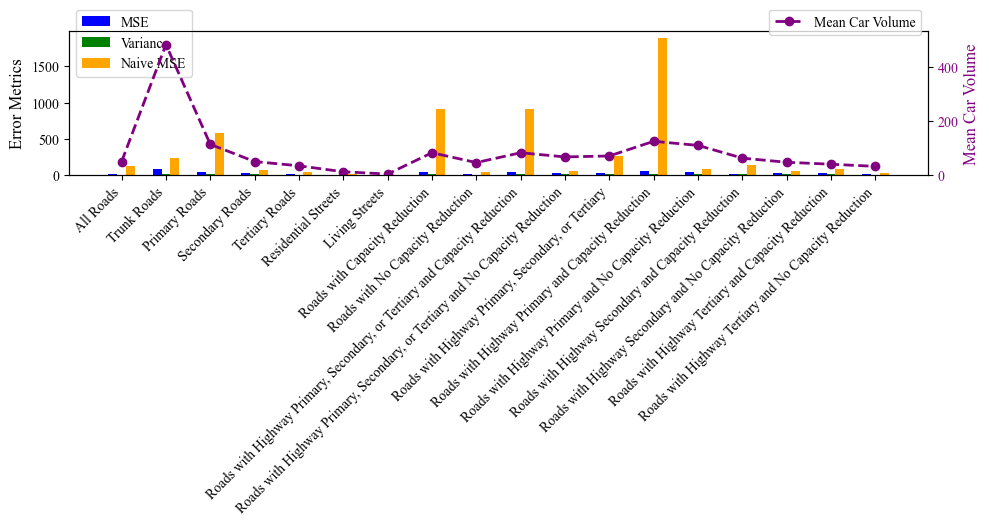

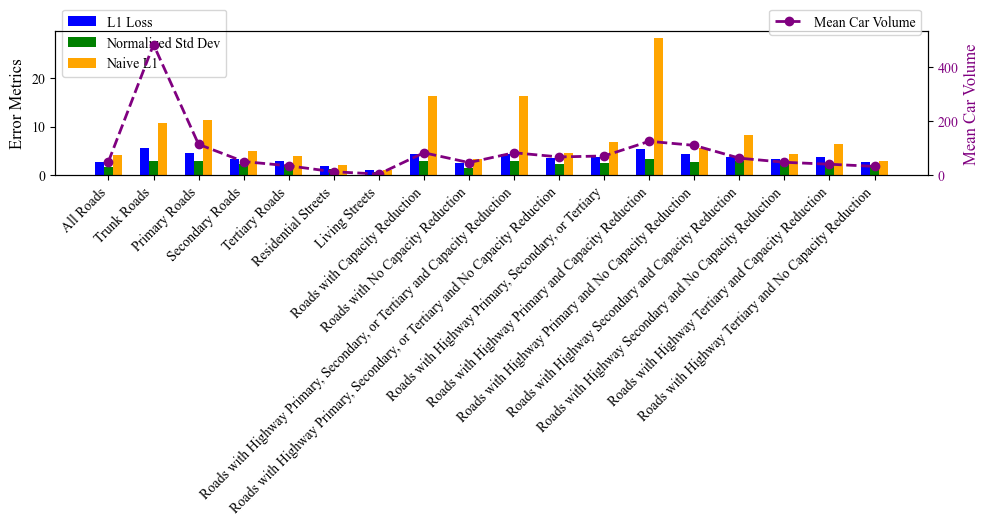

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

x = np.arange(len(road_types))
bar_width = 0.2

# Bar plot for MSE, Variance, and Naive MSE
ax1.bar(x - bar_width, [metrics_by_type[rt]['mse'] for rt in road_types], 
        width=bar_width, label="MSE", color="blue")
ax1.bar(x, [metrics_by_type[rt]['variance'] for rt in road_types], 
        width=bar_width, label="Variance", color="green")
ax1.bar(x + bar_width, [metrics_by_type[rt]['naive_mse'] for rt in road_types], 
        width=bar_width, label="Naive MSE", color="orange")
ax1.set_ylabel("Error Metrics", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(road_types, rotation=45, ha="right")
ax1.legend(loc="upper left", fontsize=10, bbox_to_anchor=(0, 1.2))

# Second y-axis for Mean Car Volume
ax2 = ax1.twinx()
ax2.plot(x, [metrics_by_type[rt]['mean_car_vol'] for rt in road_types], 
         label="Mean Car Volume", color="purple", marker="o", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Mean Car Volume", fontsize=12, color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.set_ylim(0, max([metrics_by_type[rt]['mean_car_vol'] for rt in road_types]) * 1.1)
ax2.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1, 1.2))

plt.savefig("mse_vs_variance.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

# Plot 2: L1 vs Normalized Standard Deviation
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

# Bar plot for L1, Normalized Std Dev, and Naive L1
ax1.bar(x - bar_width, [metrics_by_type[rt]['l1'] for rt in road_types], 
        width=bar_width, label="L1 Loss", color="blue")
ax1.bar(x, [metrics_by_type[rt]['std_dev_normalized'] for rt in road_types], 
        width=bar_width, label="Normalized Std Dev", color="green")
ax1.bar(x + bar_width, [metrics_by_type[rt]['naive_l1'] for rt in road_types], 
        width=bar_width, label="Naive L1", color="orange")
ax1.set_ylabel("Error Metrics", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(road_types, rotation=45, ha="right")
ax1.legend(loc="upper left", fontsize=10, bbox_to_anchor=(0, 1.2))

# Second y-axis for Mean Car Volume
ax2 = ax1.twinx()
ax2.plot(x, [metrics_by_type[rt]['mean_car_vol'] for rt in road_types], 
         label="Mean Car Volume", color="purple", marker="o", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Mean Car Volume", fontsize=12, color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.set_ylim(0, max([metrics_by_type[rt]['mean_car_vol'] for rt in road_types]) * 1.1)
ax2.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1, 1.2))

plt.savefig("l1_vs_normalized_std_dev.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [15]:
def create_summary_table(metrics_by_type):
    # Create DataFrame with selected metrics
    df = pd.DataFrame({
        'Road Type': metrics_by_type.keys(),
        'R²': [metrics_by_type[rt]['r_squared'] for rt in metrics_by_type],
        'MSE': [metrics_by_type[rt]['mse'] for rt in metrics_by_type],
        'L1': [metrics_by_type[rt]['l1'] for rt in metrics_by_type],
        'Mean Volume': [metrics_by_type[rt]['mean_car_vol'] for rt in metrics_by_type],
        'CV%': [metrics_by_type[rt]['cv_percent'] for rt in metrics_by_type]
    })
    
    # Format numbers
    df['R²'] = df['R²'].round(3)
    df['MSE'] = df['MSE'].round(1)
    df['L1'] = df['L1'].round(1)
    df['Mean Volume'] = df['Mean Volume'].round(0)
    df['CV%'] = df['CV%'].round(1)
    
    # Convert to LaTeX table
    latex_table = df.to_latex(index=False, float_format=lambda x: '%.3f' % x)
    
    return df, latex_table

df, latex_table = create_summary_table(metrics_by_type)
print(df)  # For preview

                                            Road Type              R²  \
0                                           All Roads  tensor(0.8159)   
1                                         Trunk Roads  tensor(0.6301)   
2                                       Primary Roads  tensor(0.9083)   
3                                     Secondary Roads  tensor(0.6241)   
4                                      Tertiary Roads  tensor(0.5075)   
5                                 Residential Streets  tensor(0.2830)   
6                                      Living Streets  tensor(0.1142)   
7                       Roads with Capacity Reduction  tensor(0.9552)   
8                    Roads with No Capacity Reduction  tensor(0.4745)   
9   Roads with Highway Primary, Secondary, or Tert...  tensor(0.9552)   
10  Roads with Highway Primary, Secondary, or Tert...  tensor(0.4188)   
11  Roads with Highway Primary, Secondary, or Tert...  tensor(0.8636)   
12  Roads with Highway Primary and Capacity Reducti

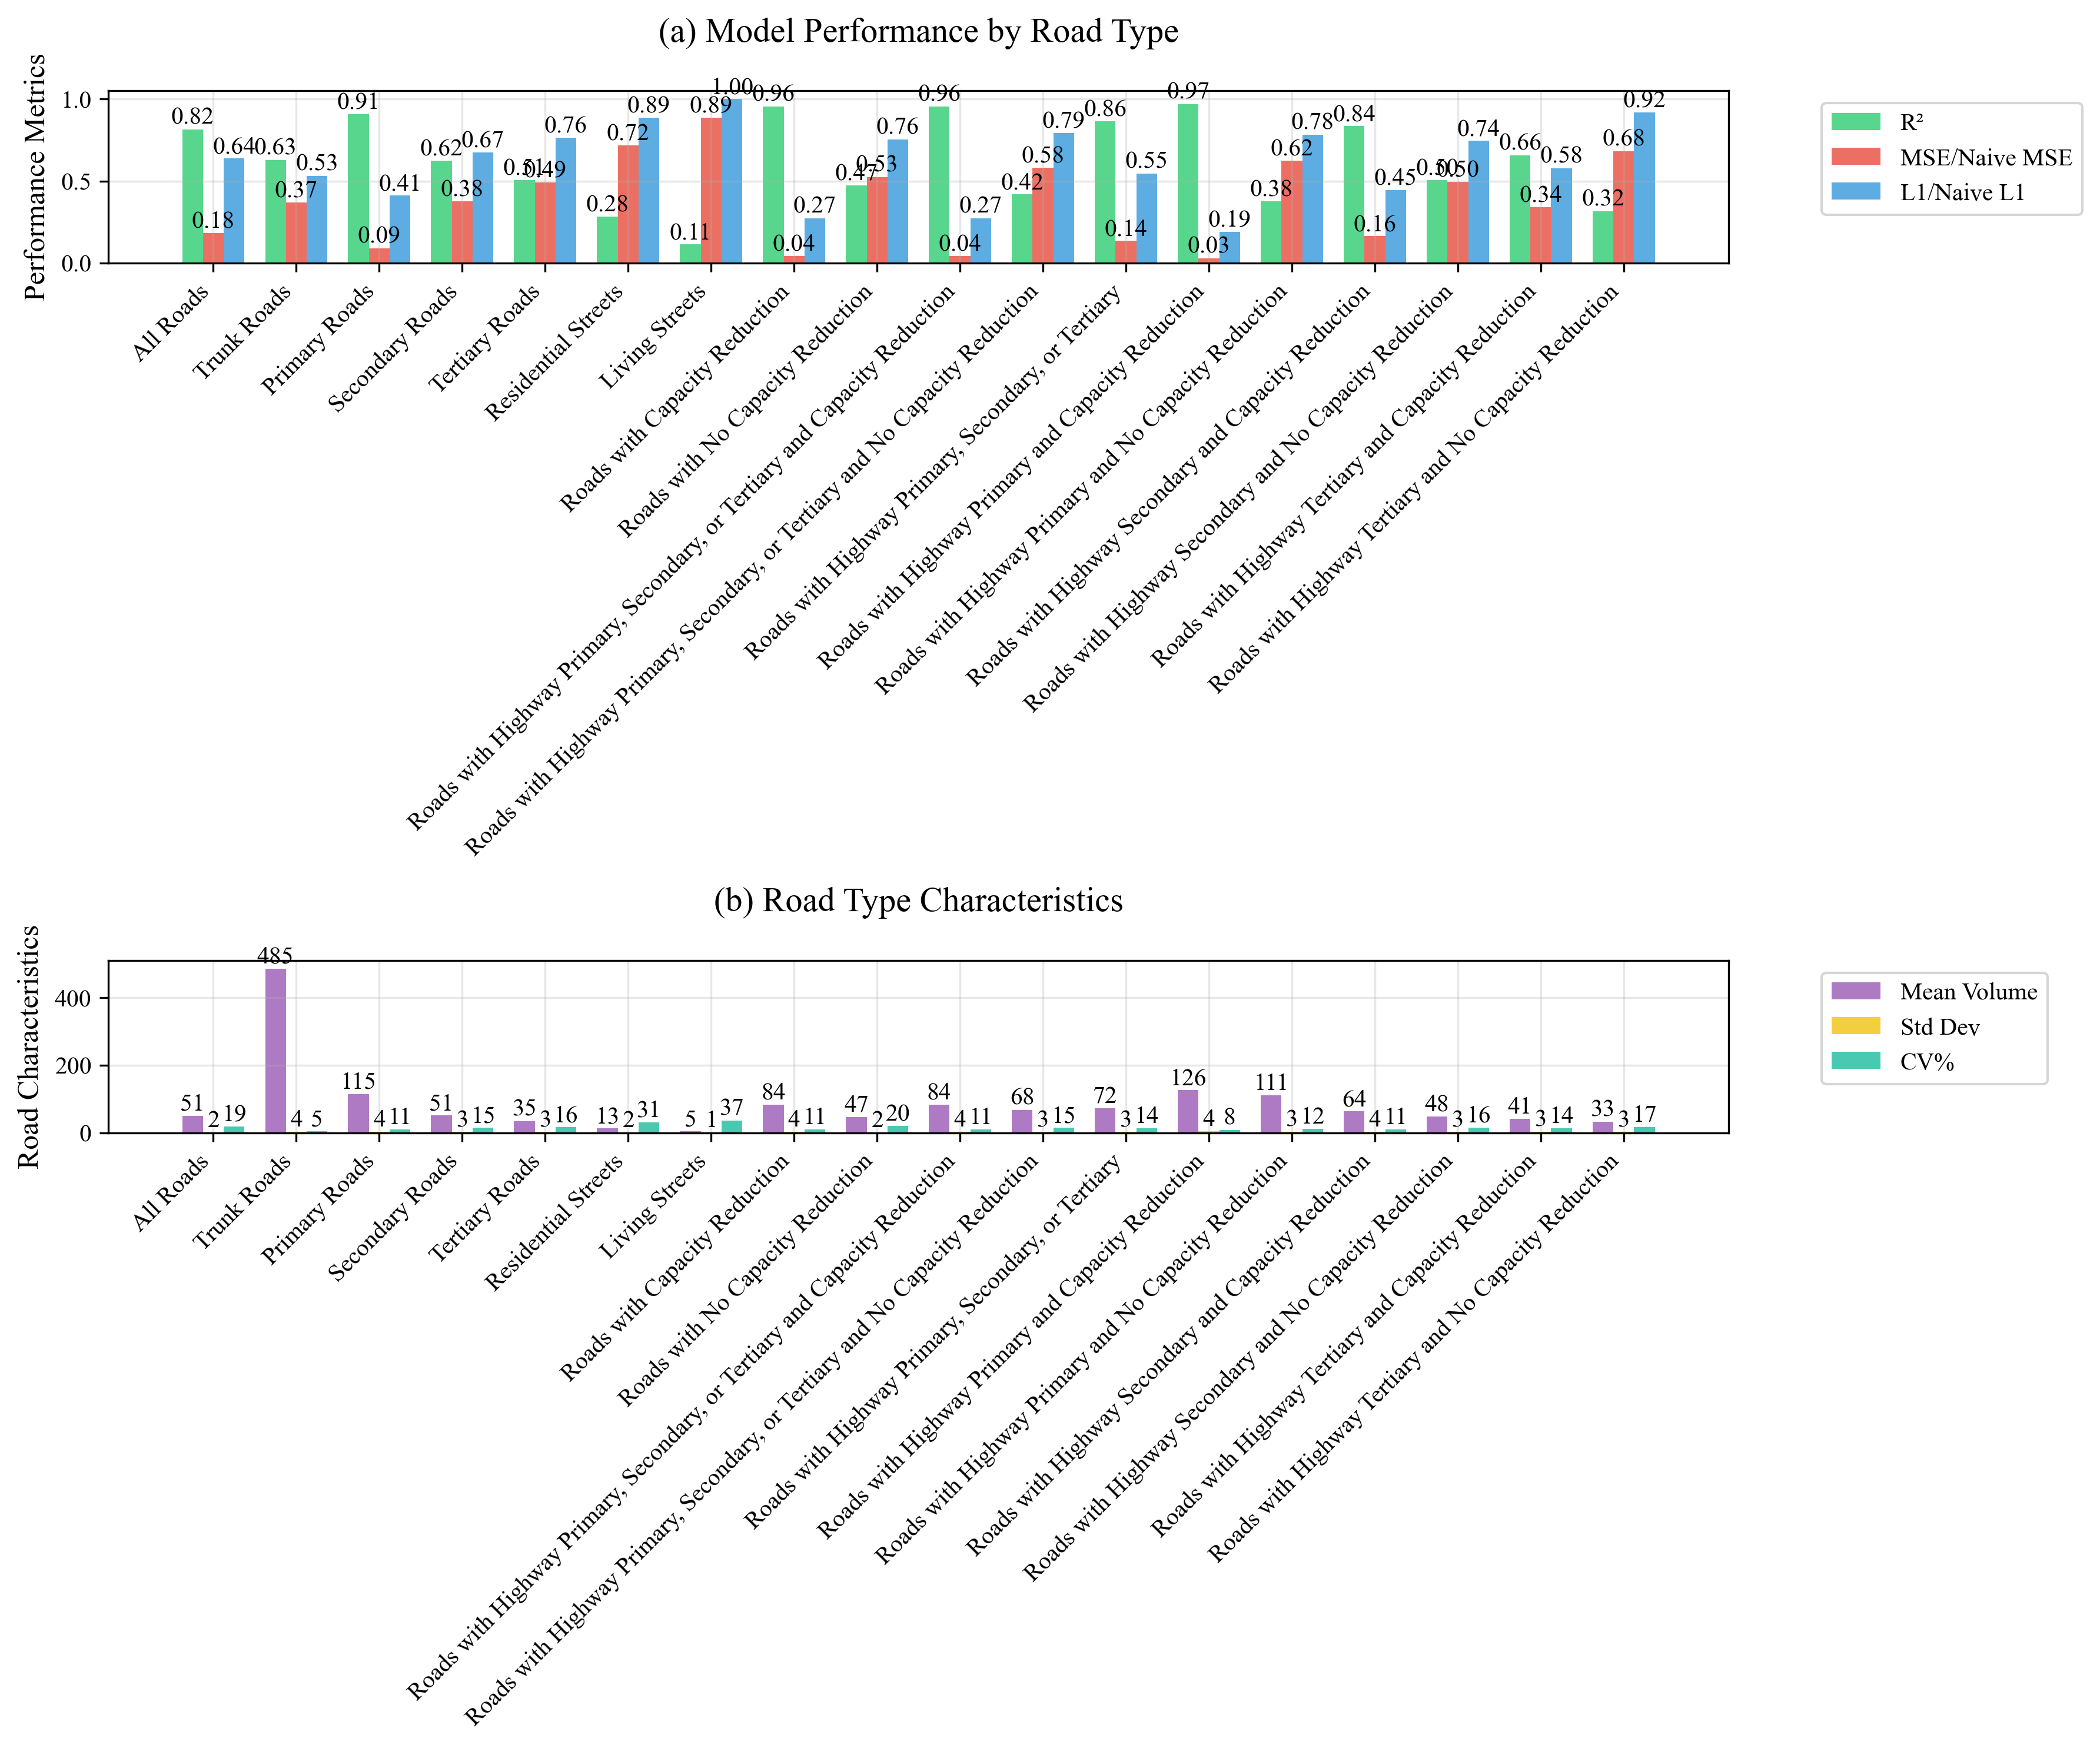

In [16]:
def create_performance_comparison_plot(metrics_by_type):
    # Set style for scientific publication
    plt.style.use('default')  # Using default matplotlib style
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    road_types = list(metrics_by_type.keys())
    x = np.arange(len(road_types))
    bar_width = 0.25
    
    # First subplot: Prediction Performance
    performance_bars1 = ax1.bar(x - bar_width, [metrics_by_type[rt]['r_squared'] for rt in road_types], 
            width=bar_width, label="R²", color='#2ecc71', alpha=0.8)
    performance_bars2 = ax1.bar(x, [metrics_by_type[rt]['mse']/metrics_by_type[rt]['naive_mse'] for rt in road_types], 
            width=bar_width, label="MSE/Naive MSE", color='#e74c3c', alpha=0.8)
    performance_bars3 = ax1.bar(x + bar_width, [metrics_by_type[rt]['l1']/metrics_by_type[rt]['naive_l1'] for rt in road_types], 
            width=bar_width, label="L1/Naive L1", color='#3498db', alpha=0.8)
    
    # Add value labels on the bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
    
    add_value_labels(performance_bars1)
    add_value_labels(performance_bars2)
    add_value_labels(performance_bars3)
    
    ax1.set_ylabel("Performance Metrics", fontsize=12)
    ax1.set_title("(a) Model Performance by Road Type", fontsize=14, pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(road_types, rotation=45, ha='right')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Second subplot: Road Characteristics
    characteristics_bars1 = ax2.bar(x - bar_width, [metrics_by_type[rt]['mean_car_vol'] for rt in road_types], 
            width=bar_width, label="Mean Volume", color='#9b59b6', alpha=0.8)
    characteristics_bars2 = ax2.bar(x, [metrics_by_type[rt]['std_dev'] for rt in road_types], 
            width=bar_width, label="Std Dev", color='#f1c40f', alpha=0.8)
    characteristics_bars3 = ax2.bar(x + bar_width, [metrics_by_type[rt]['cv_percent'] for rt in road_types], 
            width=bar_width, label="CV%", color='#1abc9c', alpha=0.8)
    
    # Add value labels
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom')
    
    add_value_labels(characteristics_bars1)
    add_value_labels(characteristics_bars2)
    add_value_labels(characteristics_bars3)
    
    ax2.set_ylabel("Road Characteristics", fontsize=12)
    ax2.set_title("(b) Road Type Characteristics", fontsize=14, pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(road_types, rotation=45, ha='right')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save and show the plot
    plt.savefig("road_type_analysis.png", bbox_inches='tight', dpi=300)
    plt.show()

create_performance_comparison_plot(metrics_by_type)